# ***NUTRIWISE.io***
#### *Trouve les meilleurs ingrédients pour le plat que tu veux manger !*
***
## Problématique
Après une réflexion intense, j'ai enfin choisi ! Ce soir, ce sera spaghetti à la bolognaise.\
Arrivé devant le rayon : difficile ! Un éventail large de pâtes et sauces...\
Mais quels ingrédients sont les meilleurs pour ma santé ? L'environnement ?\
Je n'ai pas envie de scanner chaque code-barre, il me faut quelque chose qui me dise instantanément quoi prendre !\
La solution : **NUTRIWISE.io**

## Données
### Source
Nous utiliserons ici le jeu de données `fr.openfoodfacts.org.products.csv` fourni par OpenFoodFacts.

### Variables utilisées

Après exploration des données ***NUTRIWISE.io*** va utiliser les données suivantes :`['code',  'product_name', 'main_category_fr', 'countries_tags', 'manufacturing_places_tags', 'nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade','carbon-footprint_100g', 'additives_n', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']`

Le but va être de créer un score mêlant le nutriscore et l'ecoscore pour trouver l'ingrédient optimal.
Lorsque le nutriscore est indisponible, nous allons essayer de le déterminer grâce aux teneurs en sucre, gras, gras saturé et sel.
Lorsque l'ecoscore est indisponible, nous allons essayer de le déterminer grâce à l'empreinte carbone.


## Lecture des données

In [139]:
# Imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [115]:
# Reading of the CSV file and creation of the DataFrame
nrows=500000 # This value for the tests to improve the running time
cols = ['code',  'product_name', 'main_category_fr', 'countries_tags', 'manufacturing_places_tags', \
        'nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade', \
        'additives_n','carbon-footprint_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']

start_time = time.time()
# This line to run the reading on a nrows sample
# df= pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True, nrows=nrows)

#This line to run the reading on the entire CSV file
df= pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True)

end_time = time.time()
print(f"Running time to read csv : {end_time - start_time:.2f} seconds")

total_df_length = len(df)
formatted_total_df_length = format(total_df_length, ',').replace(',', ' ')

/tmp/ipykernel_6207/4131799704.py:12: DtypeWarning: Columns (0,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True)


Running time to read csv : 62.03 seconds


## Nettoyage des données
### Démarche
#### Contrainte géographique

Dans un premier temps, nous allons nous concentrer sur la France. Notre première étape sera donc de garder les ingrédients seulement vendus en France.
Ensuite, nous enlèverons les doublons de cette base.

6 lignes étaient des doublons parfaits.
Au total, il y avait 2 829 821 lignes dans la base initiale. 
Après avoir gardé seulement les produits vendus en France, il y a 970 916, soit 34.31 % de la base initiale.


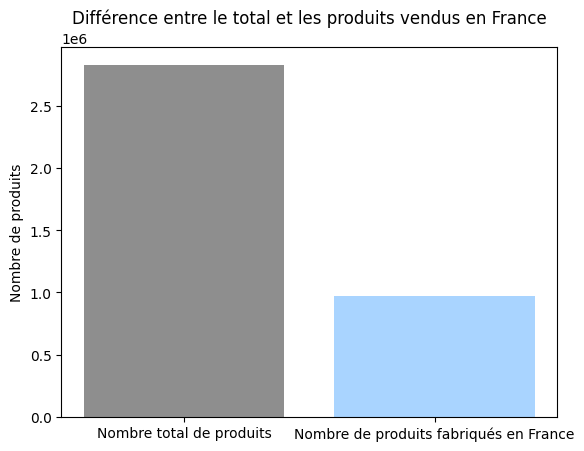

In [117]:
# Drop rows with the selling countries are not known
df = df.dropna(subset=['countries_tags'])


# Filter the rows with only countries_tags that contains 'france'
france_df = df[df['countries_tags'].str.contains('france')]
france_df = france_df[cols]
france_df_length = len(france_df)
formatted_france_df_length = format(france_df_length, ',').replace(',', ' ')
france_df = france_df.drop_duplicates()
france_df_uniques_length = len(france_df)
print(f"{france_df_length - france_df_uniques_length} lignes étaient des doublons parfaits.")
print(f"Au total, il y avait {formatted_total_df_length} lignes dans la base initiale. \nAprès avoir gardé seulement les produits vendus en France, il y a {formatted_france_df_length}, soit {round(france_df_length/total_df_length* 100,2)} % de la base initiale.")

# GRAPH
values = [total_df_length, france_df_length]
labels = ["Nombre total de produits", "Nombre de produits fabriqués en France"]
fig, ax = plt.subplots()
ax.bar(labels, values, color=['#8E8E8E', '#A9D4FF'])
ax.set_ylabel('Nombre de produits')
ax.set_title('Différence entre le total et les produits vendus en France')

plt.show()

#### Erreurs lexicales

In [128]:
# check if there are two different data types in each column
for col in france_df.columns:
    if france_df[col].nunique() > 1:
        print(f"{col} : {france_df[col].dtypes}")
        
print("\n On peut voir qu'il n'y a rien de particulier ici. Ceux qui doivent être des nombres sont des nombres, ceux qui doivent être du texte sont du texte.")

code : object
product_name : object
main_category_fr : object
countries_tags : object
manufacturing_places_tags : object
nutriscore_score : float64
nutriscore_grade : object
ecoscore_score : float64
ecoscore_grade : object
carbon-footprint_100g : float64
additives_n : float64
sugars_100g : float64
fat_100g : float64
saturated-fat_100g : float64
sodium_100g : float64

 On peut voir qu'il n'y a rien de particulier ici. Ceux qui doivent être des nombres sont des nombres, ceux qui doivent être du texte sont du texte.


#### Gestion des valeurs nulles
Dans notre cas, nous allons avoir essentiellement besoin du **Nutriscore** et de l'**Eco-score**. \
Si ces deux valeurs ne sont pas présentes, nous allons essayer de les déduire grâce aux informations nutritionnelles et écologiques présentes pour le produit.
Nous allons donc éliminer les valeurs où tous les champs : `['nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade','carbon-footprint_100g', 'additives_n', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']` sont nuls. \
Si une valeur est présente, nous gardons la ligne pour le moment pour essayer de la déduire. \

En lançant une fois la fonction dropna, nous vyons que l'ecoscore grade est à unknown est pas forcément à nul.
Je vais donc voir quelles sont les valeurs des ecoscore_grade et nutriscore_grade

In [135]:
copied_df = france_df.dropna(subset=['carbon-footprint_100g', 'additives_n', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g'], thresh=1)
copied_df.sample(n=5)

,code,product_name,main_category_fr,countries_tags,manufacturing_places_tags,nutriscore_score,nutriscore_grade,ecoscore_score,ecoscore_grade,carbon-footprint_100g,additives_n,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g
998699,2609264305609,Rice crackers,NaN,en:france,NaN,NaN,NaN,NaN,unknown,NaN,NaN,0.6,9.8,2.2,0.68
1499424,3760240722380,Riz spécial risotto,Riz,en:france,NaN,1.0,b,27.0,d,NaN,0.0,0.2,0.9,0.1,0.04
489293,0333669066767,Ravioli chèvre et tomates,Pâtes alimentaires,en:france,NaN,14.0,d,NaN,unknown,NaN,2.0,2.1,10.5,6.1,0.60
1720964,4260289448498,Nu3 Organic Pumpkin Seed Oil,NaN,en:france,NaN,NaN,NaN,NaN,unknown,NaN,NaN,0.0,100.0,18.5,NaN
1110127,3193840001638,Confiture myrtille sauvage au sucre de canne,Confitures de myrtilles,en:france,NaN,NaN,NaN,60.0,b,NaN,1.0,61.0,0.0,0.0,NaN


In [138]:
cols = ['nutriscore_grade', 'ecoscore_grade']
for col in cols:
    print(f"{col} : {france_df[col].unique()}")

nutriscore_grade : [nan 'a' 'd' 'b' 'c' 'e']
ecoscore_grade : ['unknown' 'd' 'c' 'b' 'e' 'not-applicable' 'a' nan]


Pour le nutriscore, pas de problème.\
Pour l'eco-score, nous avons deux valeurs qui ne sont pas utilisables : unknown et and not-applicable. Nous les remplacerons par nan. \
Nous relançons ensuite la même fonction que précédement.

In [141]:
france_df['ecoscore_grade'] = france_df['ecoscore_grade'].replace(['unknown', 'not-applicable'], np.nan)
copied_df = france_df.dropna(subset=['carbon-footprint_100g', 'additives_n', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g'], thresh=1)
copied_df.sample(n=5)

,code,product_name,main_category_fr,countries_tags,manufacturing_places_tags,nutriscore_score,nutriscore_grade,ecoscore_score,ecoscore_grade,carbon-footprint_100g,additives_n,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g
444592,0211466022431,Chorizo fort olives noires de nyons,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,38.0,15.0,1.840
1263734,3375644009083,Le cassoulet Toulousain au porc,Cassoulets toulousains,en:france,NaN,-4.0,a,78.0,b,NaN,0.0,0.6,5.9,2.0,0.264
2566012,8433329068871,Magro de cerdo cocido,Porc,en:france,NaN,12.0,d,NaN,NaN,NaN,NaN,0.5,9.7,3.8,0.640
1145395,3252540950063,Fromage,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,31.0,21.0,0.720
518274,625486101074,Mammoth mass,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,3.1,1.3,0.080


<Axes: >

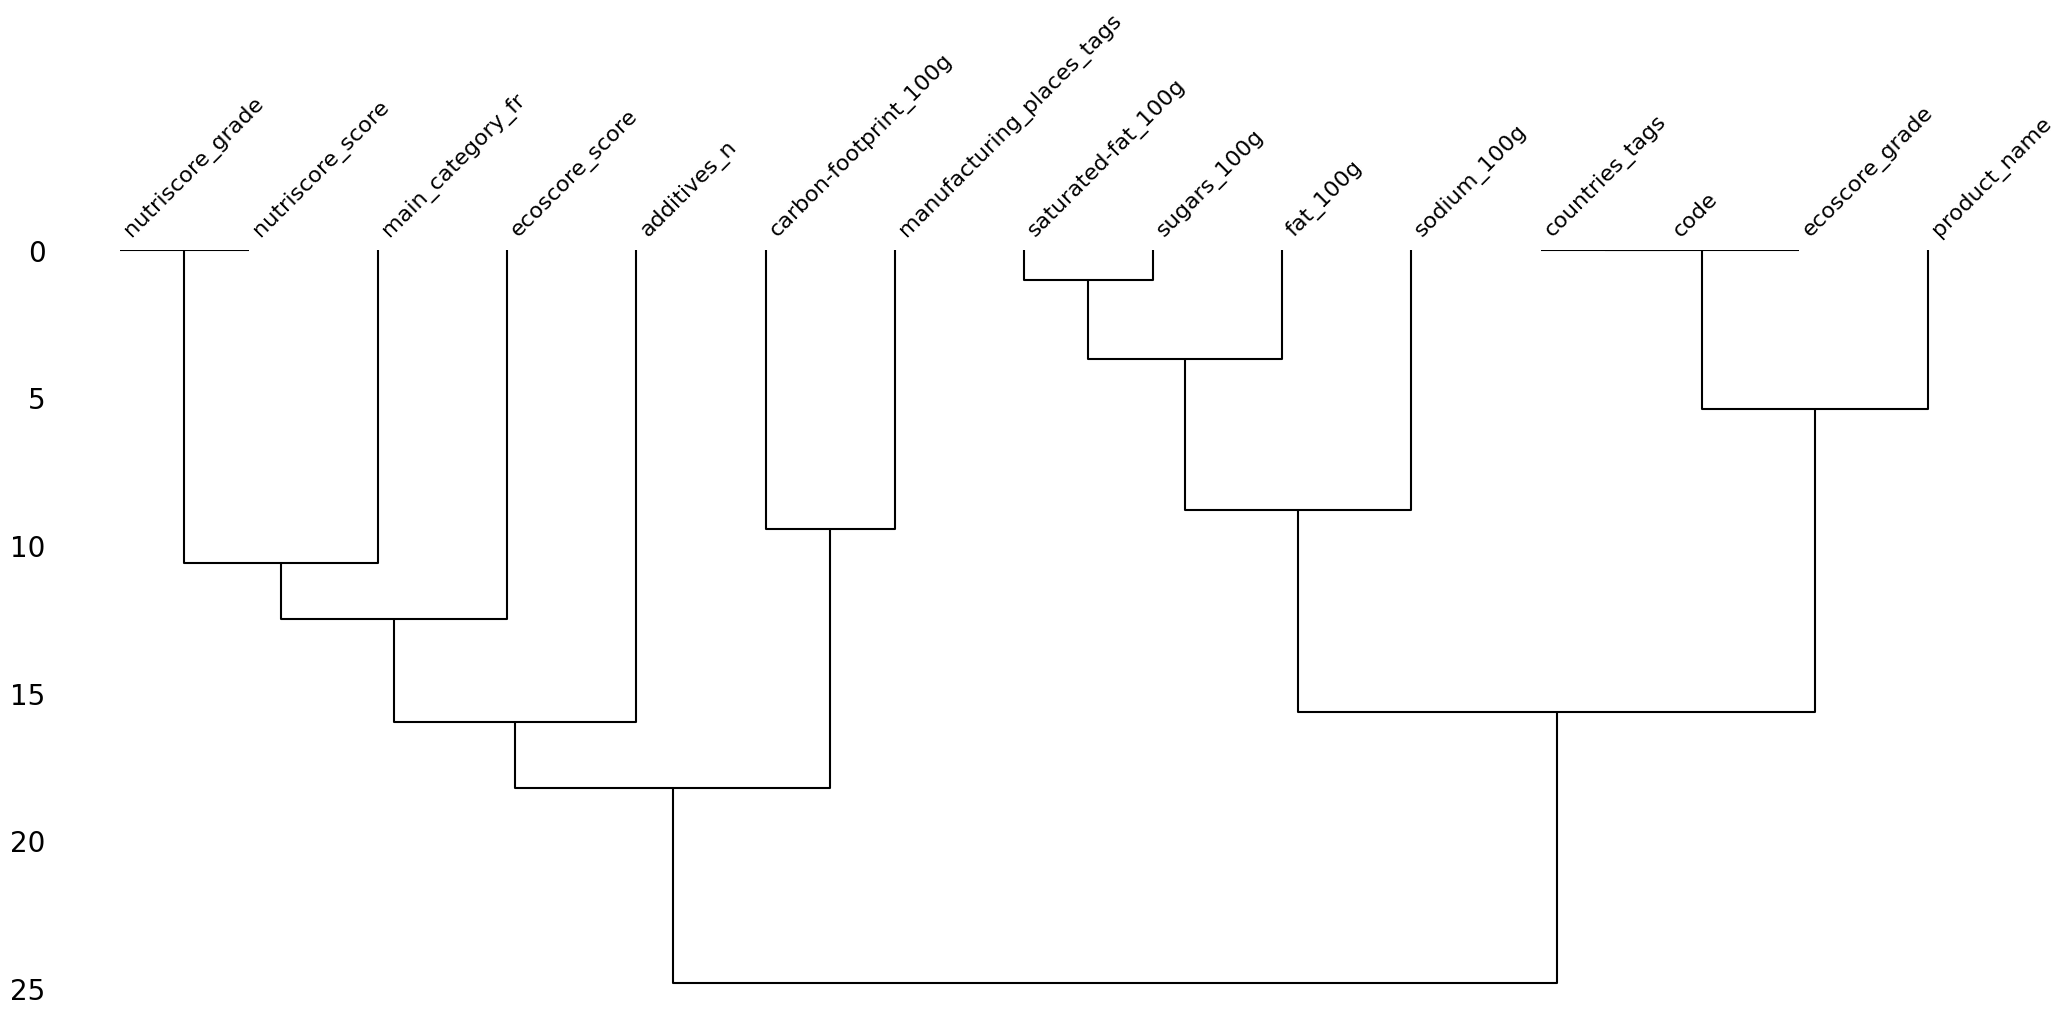

In [96]:
import missingno as msno
sample_percentage = 0.1
# france_df_sample = int(france_df_length * sample_percentage)
france_df_sample = 1000




msno.dendrogram(france_df.sample(france_df_sample))


In [44]:
cannot_be_na_cols = ['sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g', 'carbon-footprint_100g']
# remove rows where any of the values in the selected columns are missing
cleaned_df = df.dropna(subset=cannot_be_na_cols, how='all')
cleaned_df

,code,product_name,manufacturing_places_tags,countries_tags,additives_n,nutriscore_score,nutriscore_grade,data_quality_errors_tags,main_category_fr,fat_100g,saturated-fat_100g,sugars_100g,sodium_100g,carbon-footprint_100g
1,0000000000000207025004,Andrè,NaN,en:germany,NaN,NaN,NaN,en:energy-value-in-kcal-does-not-match-value-c...,NaN,2.00,2.00,12.60,NaN,NaN
2,00000000000003429145,L.casei,NaN,en:spain,0.0,NaN,NaN,NaN,NaN,1.40,0.90,9.80,0.040,NaN
3,00000000000026772226,Skyr,NaN,en:france,NaN,-5.0,a,NaN,Fromages à la crème,0.20,0.10,3.90,0.036,NaN
4,0000000000017,Vitória crackers,NaN,en:france,NaN,NaN,NaN,NaN,NaN,7.00,3.08,15.00,0.560,NaN
6,000000000003327986,Filetes de pollo empanado,NaN,en:spain,NaN,NaN,NaN,NaN,NaN,1.90,1.00,NaN,0.440,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,492860300329,Sliced apples with peanut butter,NaN,en:united-states,0.0,-2.0,a,NaN,Aliments à base de fruits et de légumes,13.81,1.93,9.94,0.127,NaN
499996,492860300336,Celery & carrots,NaN,en:united-states,4.0,2.0,b,NaN,Aliments à base de fruits et de légumes,7.36,0.61,3.68,0.184,NaN
499997,492860300381,Thai-style chicken wrap,NaN,en:united-states,8.0,4.0,c,NaN,Sandwichs,10.53,3.24,2.83,0.466,NaN
499998,492860300541,Caesar chicken salad,NaN,en:united-states,5.0,4.0,c,NaN,en:salted-snacks,13.07,2.83,1.41,0.481,NaN
